In [4]:
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn

from PIL import Image
import numpy as np
import pandas as pd
import os
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline



In [5]:

angry= '/kaggle/input/dog-emotions-5-classes/train_images_5_class/angry/'
frown = '/kaggle/input/dog-emotions-5-classes/train_images_5_class/frown/'
relax = '/kaggle/input/dog-emotions-5-classes/train_images_5_class/relax/'
happy = '/kaggle/input/dog-emotions-5-classes/train_images_5_class/happy/'
alert = '/kaggle/input/dog-emotions-5-classes/train_images_5_class/alert/'

alert_path = os.listdir(alert)
angry_path = os.listdir(angry)
frown_path = os.listdir(frown)
relax_path = os.listdir(relax)
happy_path = os.listdir(happy)


*show different emotions*

In [6]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

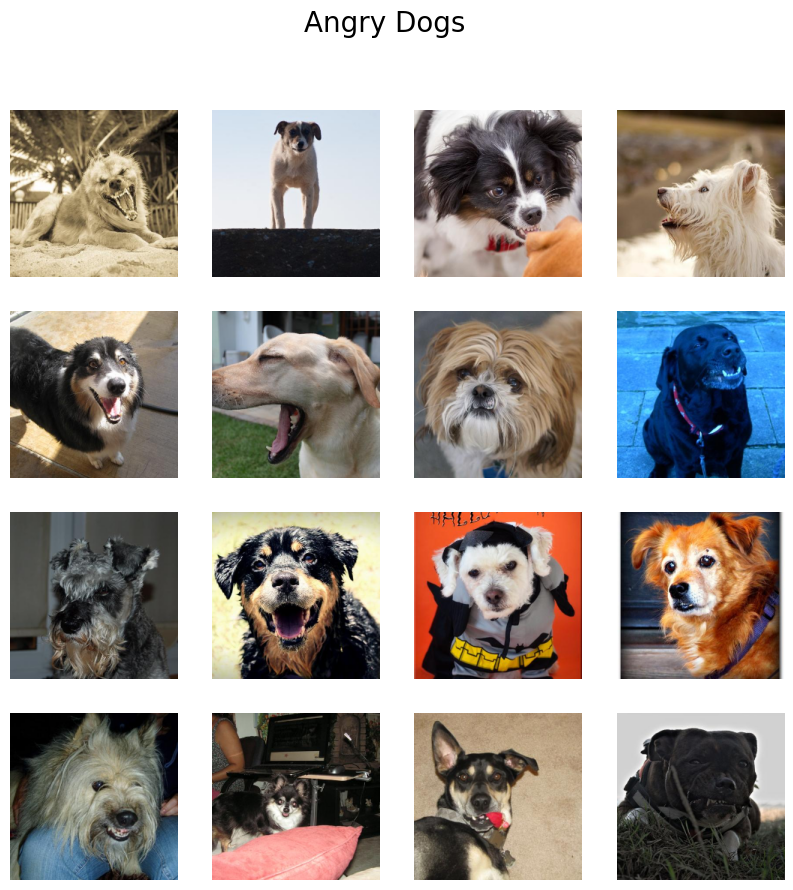

In [7]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(angry + angry_path[i]), cmap='gray')
    plt.suptitle("Angry Dogs",fontsize=20)
    plt.axis('off')

plt.show()

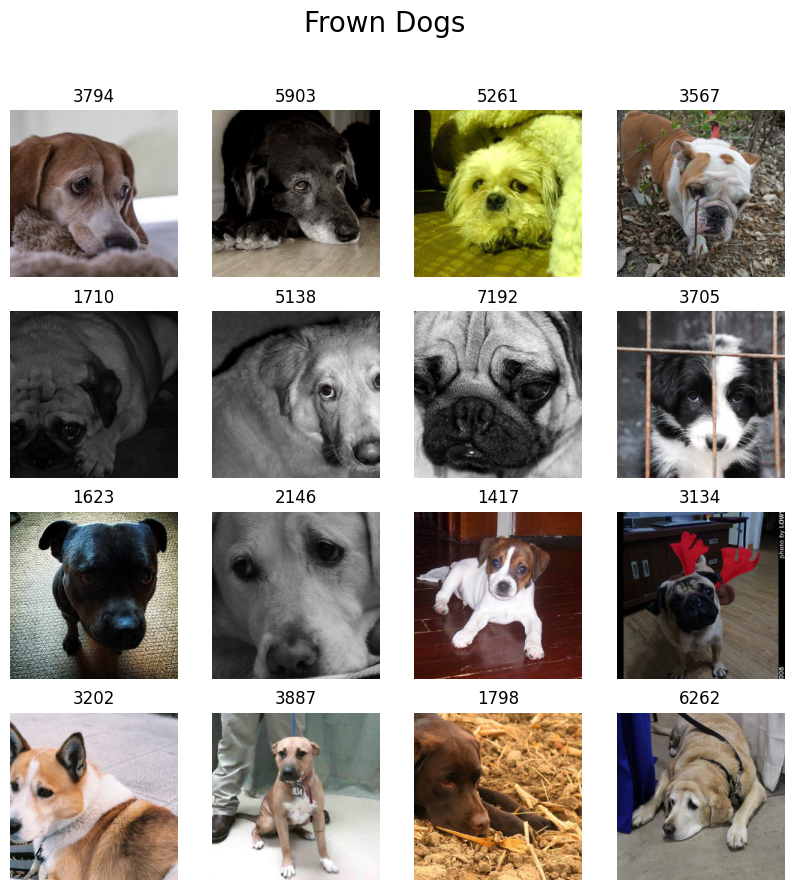

In [9]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(frown + frown_path[i]), cmap='gray')
    plt.suptitle("Frown Dogs",fontsize=20)
    plt.title(frown_path[i][:4])
    plt.axis('off')

plt.show()

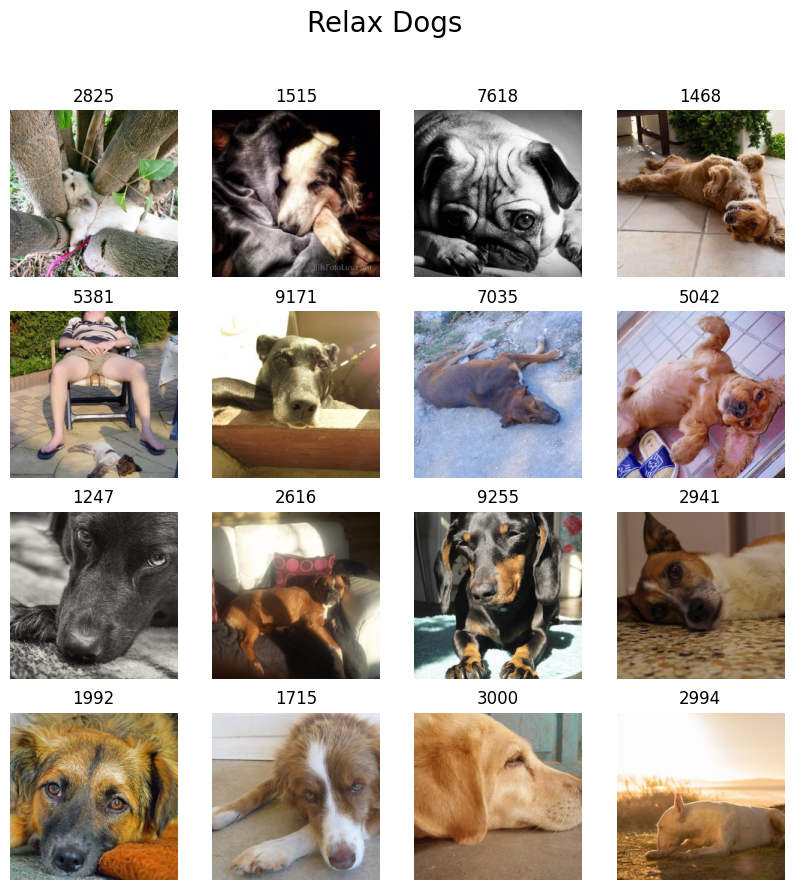

In [10]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(relax + relax_path[i]), cmap='gray')
    plt.suptitle("Relax Dogs",fontsize=20)
    plt.title(relax_path[i][:4])
    plt.axis('off')

plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(happy + happy_path[i]), cmap='gray')
    plt.suptitle("Happy Dogs",fontsize=20)
    plt.title(happy_path[i][:4])
    plt.axis('off')

plt.show()

In [11]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=299),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=299),
        transforms.CenterCrop(size=299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [13]:
from torchvision import datasets, transforms
data_path='/kaggle/input/dog-emotions-5-classes/train_images_5_class'
batch_size = 32

all_data = datasets.ImageFolder(root=data_path)

train_data_len = int(len(all_data)*0.8)
valid_data_len = int((len(all_data) - train_data_len)/2)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)
train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])

train_data.dataset.transform = image_transforms['train']
val_data.dataset.transform = image_transforms['test']
test_data.dataset.transform = image_transforms['test']
print(len(train_data), len(val_data), len(test_data))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


7460 932 933


In [16]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([32, 3, 299, 299]) torch.Size([32])


In [30]:
# resnet152, only adjust fc block
model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

n_classes = 5
n_inputs = model.fc.in_features
# Add on classifier
model.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, n_classes),
    nn.LogSoftmax(dim=1))

model.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
# resnet152, finetune layer4 and fc layer
model = models.resnet152(pretrained=True)

for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

n_classes = 5
n_inputs = model.fc.in_features
# Add on classifier
model.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, n_classes),
    nn.LogSoftmax(dim=1))

model.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [33]:
model.class_to_idx = all_data.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'alert'), (1, 'angry'), (2, 'frown'), (3, 'happy'), (4, 'relax')]

In [34]:
def train(model,
         criterion,
         optimizer,
         train_loader,
         val_loader,
         save_location,
         early_stop=3,
         n_epochs=20,
         print_every=2):
    #Initializing some variables
    valid_loss_min = np.Inf
    stop_count = 0
    valid_max_acc = 0
    history = []
    model.epochs = 0

    #Loop starts here
    for epoch in range(n_epochs):
        
        train_loss = 0
        valid_loss = 0

        train_acc = 0
        valid_acc = 0

        model.train()
        ii = 0

        for data, label in train_loader:
            ii += 1
            data, label = data.cuda(), label.cuda()
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1) # first output gives the max value in the row(not what we want), second output gives index of the highest val
            correct_tensor = pred.eq(label.data.view_as(pred)) # using the index of the predicted outcome above, torch.eq() will check prediction index against label index to see if prediction is correct(returns 1 if correct, 0 if not)
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor)) #tensor must be float to calc average
            train_acc += accuracy.item() * data.size(0)
            if ii%10 == 0:
                print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.')

        model.epochs += 1
        with torch.no_grad():
            model.eval()

            for data, label in val_loader:
                data, label = data.cuda(), label.cuda()

                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)

                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(label.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)

            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(val_loader.dataset)

            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(val_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            if (epoch + 1) % print_every == 0:
                print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

            if valid_loss < valid_loss_min:
                torch.save({
                    'state_dict': model.state_dict(),
                    'idx_to_class': model.idx_to_class
                }, save_location)
                stop_count = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            else:
                stop_count += 1

                # Below is the case where we handle the early stop case
                if stop_count >= early_stop:
                    print(f'\nEarly Stopping Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
                    model.load_state_dict(torch.load(save_location)['state_dict'])
                    model.optimizer = optimizer
                    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
                    return model, history

    model.optimizer = optimizer
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')

    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history
    

In [35]:
def evaluate(model, test_loader, criterion):
  
    classes = []
    acc_results = np.zeros(len(test_loader.dataset))
    i = 0

    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.cuda(), labels.cuda()
            output = model(data)

            for pred, true in zip(output, labels):
                _, pred = pred.unsqueeze(0).topk(1)
                correct = pred.eq(true.unsqueeze(0))
                acc_results[i] = correct.cpu()
                classes.append(model.idx_to_class[true.item()][:])
                i+=1
    results = pd.DataFrame({
      'class': classes,
      'results': acc_results    
    })
    results = results.groupby('class').mean()

    return results

In [36]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='./dog_emotions.pt',
    early_stop=4,
    n_epochs=30,
    print_every=1)

Epoch: 0	4.70% complete.
Epoch: 0	8.97% complete.
Epoch: 0	13.25% complete.
Epoch: 0	17.52% complete.
Epoch: 0	21.79% complete.
Epoch: 0	26.07% complete.
Epoch: 0	30.34% complete.
Epoch: 0	34.62% complete.
Epoch: 0	38.89% complete.
Epoch: 0	43.16% complete.
Epoch: 0	47.44% complete.
Epoch: 0	51.71% complete.
Epoch: 0	55.98% complete.
Epoch: 0	60.26% complete.
Epoch: 0	64.53% complete.
Epoch: 0	68.80% complete.
Epoch: 0	73.08% complete.
Epoch: 0	77.35% complete.
Epoch: 0	81.62% complete.
Epoch: 0	85.90% complete.
Epoch: 0	90.17% complete.
Epoch: 0	94.44% complete.
Epoch: 0	98.72% complete.

Epoch: 0 	Training Loss: 0.9082 	Validation Loss: 0.7694
		Training Accuracy: 62.73%	 Validation Accuracy: 69.10%
Epoch: 1	4.70% complete.
Epoch: 1	8.97% complete.
Epoch: 1	13.25% complete.
Epoch: 1	17.52% complete.
Epoch: 1	21.79% complete.
Epoch: 1	26.07% complete.
Epoch: 1	30.34% complete.
Epoch: 1	34.62% complete.
Epoch: 1	38.89% complete.
Epoch: 1	43.16% complete.
Epoch: 1	47.44% complete.
Epoch

/tmp/ipykernel_30/3520046641.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_location)['state_dict'])


In [37]:
history

,train_loss,valid_loss,train_acc,valid_acc
0,0.908163,0.769370,0.627346,0.690987
1,0.679125,0.824695,0.730295,0.669528
2,0.524599,0.738140,0.793700,0.711373
3,0.375287,0.977556,0.859517,0.655579
4,0.251398,1.035185,0.913405,0.701717
5,0.191723,1.231635,0.932440,0.688841
6,0.137538,1.414287,0.954960,0.698498
7,0.109314,1.401940,0.964745,0.695279
8,0.127398,1.379684,0.958177,0.678112
9,0.057378,1.413188,0.981367,0.695279


In [38]:
def test(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()

            output = model(data)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)

        test_acc = test_acc / len(test_loader.dataset)
        return test_acc

In [39]:
model.load_state_dict(torch.load('./dog_emotions.pt')['state_dict'])
test_acc = test(model.cuda(), test_loader, criterion)
print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')

/tmp/ipykernel_30/1985365111.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./dog_emotions.pt')['state_dict'])


The model has achieved an accuracy of 71.92% on the test dataset


In [40]:
print(evaluate(model, test_loader, criterion))


        results
class          
alert  0.722513
angry  0.563452
frown  0.632979
happy  0.900000
relax  0.796610
